<p style="font-size:24px;text-align:center"> <b>Personalized medicine for cancer treatment</b> </p> 
<p style="font-size:16px;text-align:center">by </p>
<p style="font-size:16px;text-align:center"><b>Yaswanth Reddy Manukonda (G01337128)</b></p>
<p style="font-size:16px;text-align:center"><b>Aravind Kommineni (G01327447)</b></p>

<p style="font-size:14px;"> <a href="https://www.kaggle.com/c/msk-redefining-cancer-treatment/">Problem Source (Kaggle link)</a> </p>
<p style="font-size:14px;"> <b>Data provided by:</b> Memorial Sloan Kettering Cancer Center (MSKCC)</p>
<p style="font-size:14px;"> <b>Dataset:</b> Download <b>training_variants.zip</b> and <b>training_text.zip</b> from Kaggle.</p> 
<h6 style="font-size:16px;">Problem statement : </h6>
<p> Currently, the interpretation of genetic mutations that are making the cancer-causing tumor grow is identified manually by the pathologists with the help of research literature for every single genetic mutation. This is very tedious and time-consuming task. So, we need to develop a machine learning model that can read the research literature text given in the dataset and classify the class of a genetic mutation. Once the class of the mutation is identified, the personalized medicine can be developed at ease by the medical experts. As the errors in classifying the gene class could be very costly, our model needs to classify the data with as lowest log loss possible.</p>

<h6 style="font-size:20px;text-align:center">Exploratory Data Analysis</h6>

<h6 style="font-size:16px;">Importing Libraries</h6>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import math
import numpy as np
from collections import defaultdict
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
warnings.filterwarnings("ignore")

<h6 style="font-size:16px;">Reading Gene and Variation data </h6>

In [2]:
trainData = pd.read_csv('./data/training_variants')

<h6 style="font-size:16px;">Reading Text data </h6>

In [3]:
trainData_text =pd.read_csv("./data/training_text",sep="\|\|",names=["ID","TEXT"],skiprows=1)

<h6 style="font-size:16px;">Pre-processing the text data</h6>

In [4]:
stop_words = set(stopwords.words('english'))
def preProcessTextData(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        trainData_text[column][index] = string

#merging both gene_variations data and text data based on ID
result = pd.merge(trainData, trainData_text,on='ID', how='left')
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


<p style="font-size:16px;">Replacing the <b>NaN</b> in the TEXT feature with Gene+Variation</p>

In [5]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']
result[result["ID"]==2755]

,ID,Gene,Variation,Class,TEXT
2755,2755,BRAF,G596C,7,BRAF G596C


<h6 style="font-size:16px;">Spliting the pre-processed data into train, test and cross validation preserving the ratio of class distribution </h6>
<ul>
<li>splitting the pre-processed data into test and train by maintaining same distribution of output varaible 'y_true'</li>
<li>Now, splitting the train data into train and cross validation by maintaining same distribution of output varaible 'y_train'</li>
</ul>

In [6]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

X_train, testDF, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
trainDF, cvDF, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

print('After the data split:')
print('train data has', trainDF.shape[0],'data points')
print('test data has', testDF.shape[0],'data points')
print('cross-validation data has', cvDF.shape[0],'data points')


After the data split:
train data has 2124 data points
test data has 665 data points
cross-validation data has 532 data points


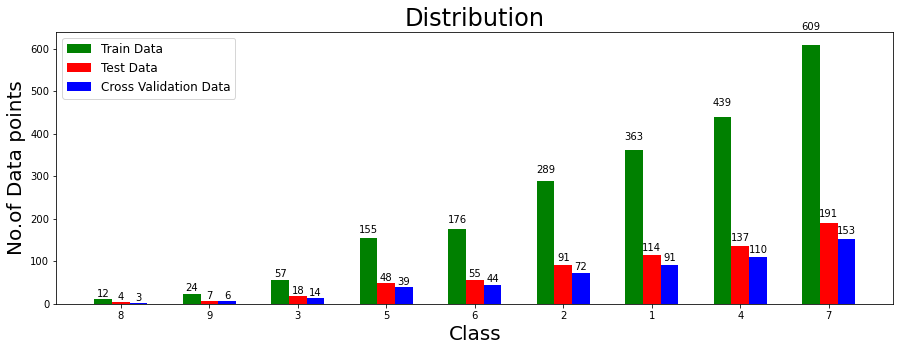

In [7]:

trainDfClassDistribution = trainDF['Class'].value_counts().sort_values()
testDfClassDistribution = testDF['Class'].value_counts().sort_values()
cvDfClassDistribution = cvDF['Class'].value_counts().sort_values()

x = cvDfClassDistribution.index.values.tolist()  # the label locations
x = np.arange(len(x))
y1 = trainDfClassDistribution.tolist()
y2 = testDfClassDistribution.tolist()
y3 = cvDfClassDistribution.tolist()
width = 0.2
plt_1 = plt.figure(figsize=(15, 5))
  
# plot data in grouped manner of bar type
rect1=plt.bar(x-0.2, y1, width, color='green')

rect2=plt.bar(x, y2, width, color='red')

rect3=plt.bar(x+0.2, y3, width, color='blue')


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rect1)
autolabel(rect2)
autolabel(rect3)

plt.xticks(x, cvDfClassDistribution.index.values.tolist())
plt.xlabel("Class",fontsize=20)
plt.ylabel("No.of Data points",fontsize=20)
plt.title('Distribution',fontsize=24)
plt.legend(['Train Data','Test Data','Cross Validation Data'],fontsize=12)
plt.show()

<h6 style="font-size:16px;">Univariate Analysis on Gene feature</h6>

In [8]:
#Get Gene variation dictionary
def getGeneVariationDict(alpha, feature, df):
    count = trainDF[feature].value_counts()
    # gvDict : Gene Variation Dict, which contains the probability array for each gene/variation
    gvDict = dict()
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in count.items():
        # vector will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vector is 9 diamensional vector - since 9 classes are there
        vector = []
        for k in range(1,10):
            classCount = trainDF.loc[(trainDF['Class']==k) & (trainDF[feature]==i)]
            # classCount.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vector.append((classCount.shape[0] + alpha*10)/ (denominator + 90*alpha))
        # we are adding the gene/variation to the dict as key and vector as value
        gvDict[i]=vector
    return gvDict
#Get Gene variation feature
def getGeneVariationFeature(alpha, feature, df):
    gvDict = getGeneVariationDict(alpha, feature, df)
    # count is similar in getGeneVariationDict
    count = trainDF[feature].value_counts()
    geneVariationFeature = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to geneVariationFeature
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to geneVariationFeature
    for index, row in df.iterrows():
        if row[feature] in dict(count).keys():
            geneVariationFeature.append(gvDict[row[feature]])
        else:
            geneVariationFeature.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return geneVariationFeature

In [9]:
uniqueGenes = trainDF['Gene'].value_counts()

<p style="font-size:16px;">there are two ways we can featurize this variable
<ol><li>one-hot encoding - It is a binary vector of the size of number of distinct elements </li><li>Response coding</li></ol></p>

<p>problem with one-hot encoding is if the number of distinct values for a categorical feature is large then One hot encoding can create sparse and large vectors</p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [10]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene response coding
trainGeneResponseCoding = np.array(getGeneVariationFeature(alpha, "Gene", trainDF))
# test gene response coding
testGeneResponseCoding = np.array(getGeneVariationFeature(alpha, "Gene", testDF))
# cross validation gene response coding
cvGeneResponseCoding = np.array(getGeneVariationFeature(alpha, "Gene", cvDF))

# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
# train gene One-hot encoding
trainGeneOnehotEnoding = gene_vectorizer.fit_transform(trainDF['Gene'])
# test gene One-hot encoding
testGeneOnehotEnoding = gene_vectorizer.transform(testDF['Gene'])
# cv gene One-hot encoding
cvGeneOnehotEnoding = gene_vectorizer.transform(cvDF['Gene'])


<p style="font-size:16px;"> There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.</p>

In [11]:
clf = LogisticRegression()
clf.fit(trainGeneOnehotEnoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(trainGeneOnehotEnoding, y_train)

predict_y = sig_clf.predict_proba(trainGeneOnehotEnoding)
print("The train log loss =",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cvGeneOnehotEnoding)
print( "The cross validation log loss =",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(testGeneOnehotEnoding)
print("The test log loss =",log_loss(y_test, predict_y))


The train log loss = 1.061830078104447
The cross validation log loss = 1.210221071416418
The test log loss = 1.2284330710574405


<p style="font-size:16px;"> from the above output, it is clear that Gene feature is stable across the train, test and CV split. Otherwise, the CV and Test errors would be significantly more than train error. Now, let us see the coverage of the genes in train data with respect to the test and cross validation dataframes  </p>

In [12]:
testCoverage=testDF[testDF['Gene'].isin(list(set(trainDF['Gene'])))].shape[0]
cvCoverage=cvDF[cvDF['Gene'].isin(list(set(trainDF['Gene'])))].shape[0]

print(np.round((testCoverage/testDF.shape[0])*100,3), "% of word of test data appeared in train data")
print(np.round((cvCoverage/cvDF.shape[0])*100,3), "% of word of cross validation data appeared in train data")

97.143 % of word of test data appeared in train data
96.429 % of word of cross validation data appeared in train data


<h6 style="font-size:16px;">Univariate Analysis on Variation feature</h6>

In [13]:
uniqueVariations = trainDF['Variation'].value_counts()

In [14]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
trainVariationResponseCoding = np.array(getGeneVariationFeature(alpha, "Variation", trainDF))
# test gene feature
testVariationResponseCoding = np.array(getGeneVariationFeature(alpha, "Variation", testDF))
# cross validation gene feature
cvVariationResponseCoding = np.array(getGeneVariationFeature(alpha, "Variation", cvDF))

# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
trainVariationOnehotEnoding = variation_vectorizer.fit_transform(trainDF['Variation'])
testVariationOnehotEnoding = variation_vectorizer.transform(testDF['Variation'])
cvVariationOnehotEnoding = variation_vectorizer.transform(cvDF['Variation'])

<p style="font-size:16px;">Now, let us see how good/stable is variation feature across test,train and cross validation to predict y_i </p>

In [15]:
clf = LogisticRegression()
clf.fit(trainVariationOnehotEnoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(trainVariationOnehotEnoding, y_train)

predict_y = sig_clf.predict_proba(trainVariationOnehotEnoding)
print("The train log loss =",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cvVariationOnehotEnoding)
print( "The cross validation log loss =",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(testVariationOnehotEnoding)
print("The test log loss =",log_loss(y_test, predict_y))


The train log loss = 1.0198998071001097
The cross validation log loss = 1.704002966524766
The test log loss = 1.7221766878956177


In [16]:
testCoverage=testDF[testDF['Variation'].isin(list(set(trainDF['Variation'])))].shape[0]
cvCoverage=cvDF[cvDF['Variation'].isin(list(set(trainDF['Variation'])))].shape[0]

print(np.round((testCoverage/testDF.shape[0])*100,3), "% of word of test data appeared in train data")
print(np.round((cvCoverage/cvDF.shape[0])*100,3), "% of word of cross validation data appeared in train data")

10.526 % of word of test data appeared in train data
10.526 % of word of cross validation data appeared in train data


<h6 style="font-size:16px;">Univariate Analysis on Text feature</h6>

In [17]:
def extractDictionary(textClass):
    dictionary = defaultdict(int)
    for index, row in textClass.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [18]:
def getTextResponseCoding(df):
    textResponseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        rowIndex = 0
        for index, row in df.iterrows():
            sumProb = 0
            for word in row['TEXT'].split():
                sumProb += math.log(((dictList[i].get(word,0)+10 )/(totalDict.get(word,0)+90)))
            textResponseCoding[rowIndex][i] = math.exp(sumProb/len(row['TEXT'].split()))
            rowIndex += 1
    return textResponseCoding

In [19]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
trainTextOnehotEncoding = text_vectorizer.fit_transform(trainDF['TEXT'])
# getting all the feature names (words)
trainTextFeatures= text_vectorizer.get_feature_names()
trainTextFeaturesCount = trainTextOnehotEncoding.sum(axis=0).A1
textDict = dict(zip(list(trainTextFeatures),trainTextFeaturesCount))

print("Total number of unique words in train data :", len(trainTextFeatures))

Total number of unique words in train data : 53270


In [20]:
dictList = []
#dictList =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    text = trainDF[trainDF['Class']==i]
    #build a word dict based on the words in that class
    dictList.append(extractDictionary(text))
    #append it to dictList

#totalDict is build on whole training text data
totalDict = extractDictionary(trainDF)

confuse_array = []
for i in trainTextFeatures:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dictList[j][i]+10 )/(totalDict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [21]:
#response coding of text features
trainTextResponseCoding  = getTextResponseCoding(trainDF)
testTextResponseCoding  = getTextResponseCoding(testDF)
cvTextResponseCoding  = getTextResponseCoding(cvDF)

In [22]:
# we convert each row values such that they sum to 1  
trainTextResponseCoding = (trainTextResponseCoding.T/trainTextResponseCoding.sum(axis=1)).T
testTextResponseCoding = (testTextResponseCoding.T/testTextResponseCoding.sum(axis=1)).T
cvTextResponseCoding = (cvTextResponseCoding.T/cvTextResponseCoding.sum(axis=1)).T

In [23]:
# don't forget to normalize every feature
trainTextOnehotEncoding = normalize(trainTextOnehotEncoding, axis=0)

# we use the same vectorizer that was trained on train data
testTextOnehotEncoding = text_vectorizer.transform(testDF['TEXT'])
# don't forget to normalize every feature
testTextOnehotEncoding = normalize(testTextOnehotEncoding, axis=0)

# we use the same vectorizer that was trained on train data
cvTextOnehotEncoding = text_vectorizer.transform(cvDF['TEXT'])

# don't forget to normalize every feature
cvTextOnehotEncoding = normalize(cvTextOnehotEncoding, axis=0)

In [24]:
clf = LogisticRegression()
clf.fit(trainVariationOnehotEnoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(trainTextOnehotEncoding, y_train)

predict_y = sig_clf.predict_proba(trainTextOnehotEncoding)
print("The train log loss =",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cvTextOnehotEncoding)
print( "The cross validation log loss =",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(testTextOnehotEncoding)
print("The test log loss =",log_loss(y_test, predict_y))


The train log loss = 0.6998802394628171
The cross validation log loss = 1.0844615189398361
The test log loss = 1.0930246478885526


In [25]:
def getIntersectedText(df):
    textVector = CountVectorizer(min_df=3)
    text = textVector.fit_transform(df['TEXT'])
    textFeatures = textVector.get_feature_names()

    textCount = text.sum(axis=0).A1
    textDict = dict(zip(list(textFeatures),textCount))
    len1 = len(set(textFeatures))
    len2 = len(set(trainTextFeatures) & set(textFeatures))
    return len1,len2

In [26]:
len1,len2 = getIntersectedText(testDF)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = getIntersectedText(cvDF)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

95.456 % of word of test data appeared in train data
98.292 % of word of Cross Validation appeared in train data


<h6 style="font-size:20px;text-align:center">Predictive Models</h6>

In [27]:
def predictAndPlot(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [28]:
trainGeneVariationOnehotEnoding = hstack((trainGeneOnehotEnoding,trainVariationOnehotEnoding))
testGeneVariationOnehotEnoding = hstack((testGeneOnehotEnoding,testVariationOnehotEnoding))
cvGeneVariationOnehotEnoding = hstack((cvGeneOnehotEnoding,cvVariationOnehotEnoding))

train_x_onehotCoding = hstack((trainGeneVariationOnehotEnoding, trainTextOnehotEncoding)).tocsr()
train_y = np.array(list(trainDF['Class']))

test_x_onehotCoding = hstack((testGeneVariationOnehotEnoding, testTextOnehotEncoding)).tocsr()
test_y = np.array(list(testDF['Class']))

cv_x_onehotCoding = hstack((cvGeneVariationOnehotEnoding, cvTextOnehotEncoding)).tocsr()
cv_y = np.array(list(cvDF['Class']))


trainGeneVariationResponseCoding = np.hstack((trainGeneResponseCoding,trainVariationResponseCoding))
testGeneVariationResponseCoding = np.hstack((testGeneResponseCoding,testVariationResponseCoding))
cvGeneVariationResponseCoding = np.hstack((cvGeneResponseCoding,cvVariationResponseCoding))

train_x_responseCoding = np.hstack((trainGeneVariationResponseCoding, trainTextResponseCoding))
test_x_responseCoding = np.hstack((testGeneVariationResponseCoding, testTextResponseCoding))
cv_x_responseCoding = np.hstack((cvGeneVariationResponseCoding, cvTextResponseCoding))


In [29]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55463)
(number of data points * number of features) in test data =  (665, 55463)
(number of data points * number of features) in cross validation data = (532, 55463)


In [30]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


In [31]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column    
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<h6 style="font-size:16px;">Naive Bayes</h6>

Log loss : 1.2816873942983924
Number of mis-classified points : 0.45112781954887216
-------------------- Confusion matrix --------------------


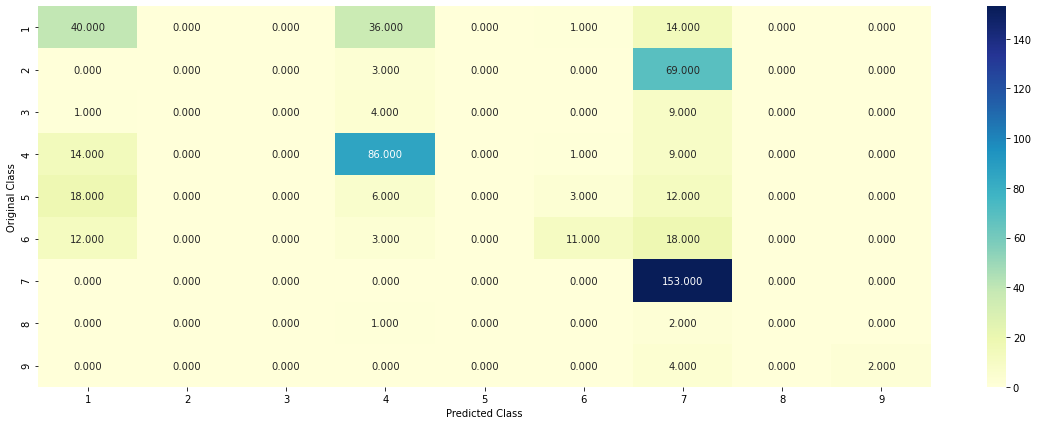

-------------------- Precision matrix (Columm Sum=1) --------------------


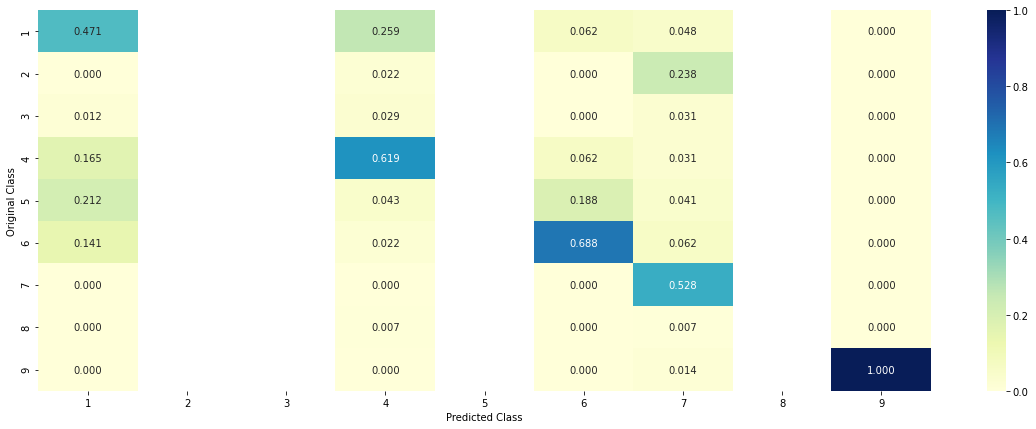

-------------------- Recall matrix (Row sum=1) --------------------


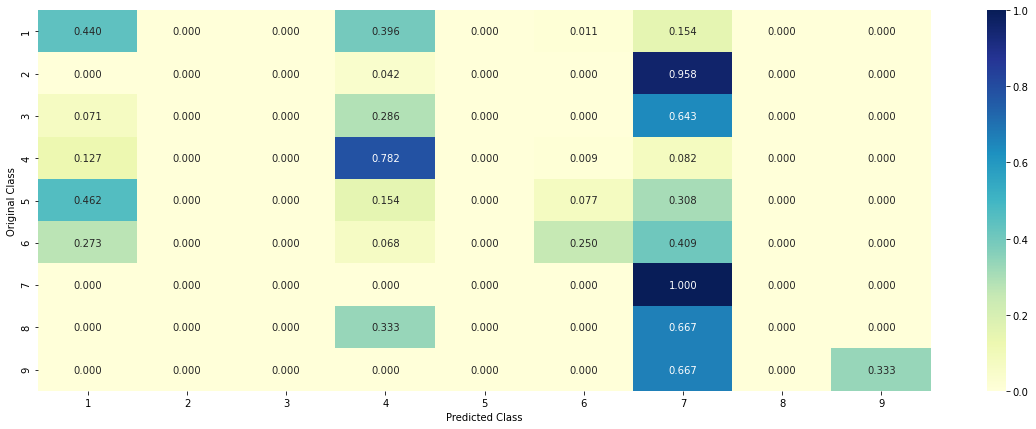

In [32]:
clf1 = MultinomialNB(alpha=0.1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
#print("Log Loss :",log_loss(cv_y, sig_clf_probs))
#print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
#plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))
predictAndPlot(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf1)

<h6 style="font-size:16px;">K Nearest Neighbour Classification</h6>

Log loss : 1.0433453975493692
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


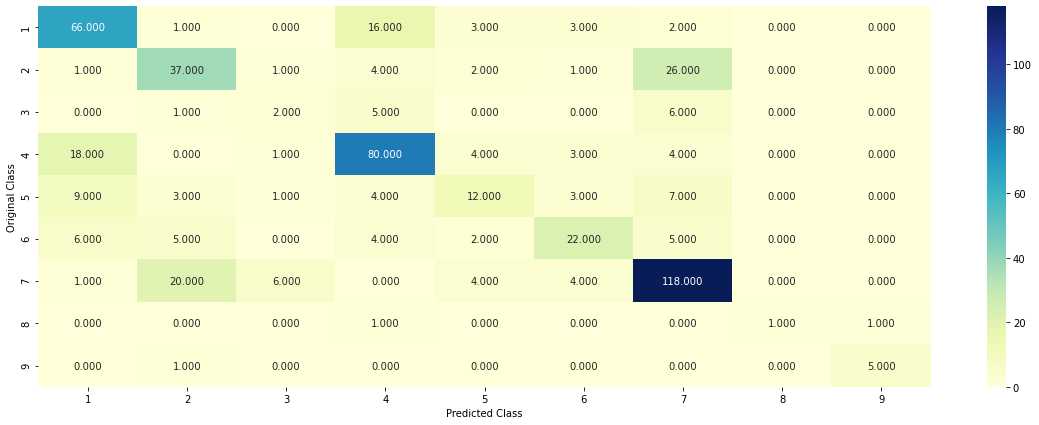

-------------------- Precision matrix (Columm Sum=1) --------------------


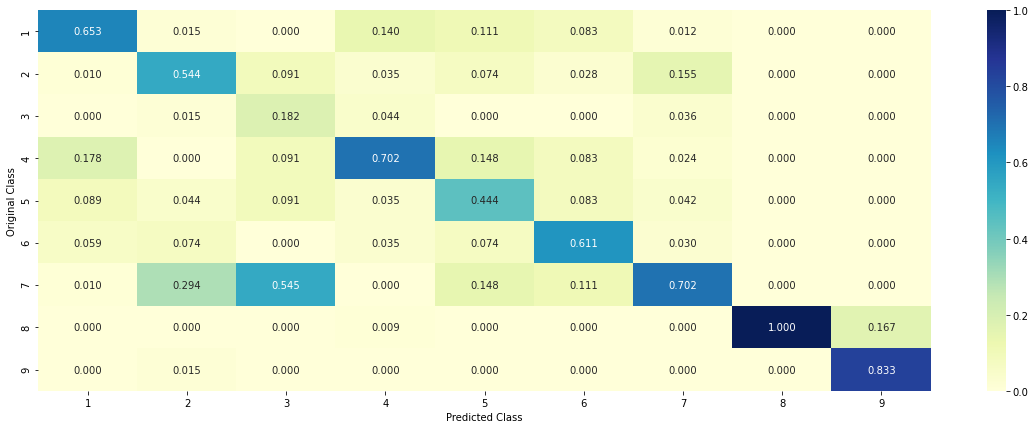

-------------------- Recall matrix (Row sum=1) --------------------


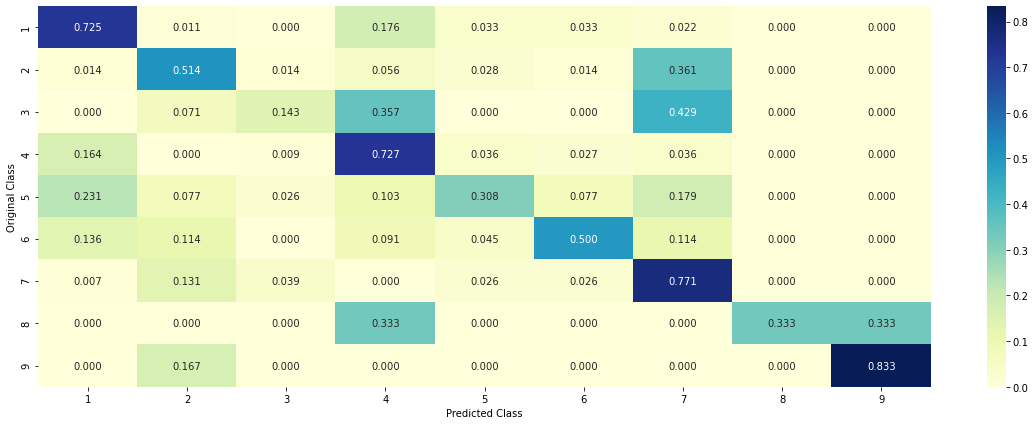

In [33]:
clf2 = KNeighborsClassifier(n_neighbors=11)
predictAndPlot(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf2)

<h6 style="font-size:16px;">Logistic Regression</h6>

Log loss : 1.0508846703477244
Number of mis-classified points : 0.3308270676691729
-------------------- Confusion matrix --------------------


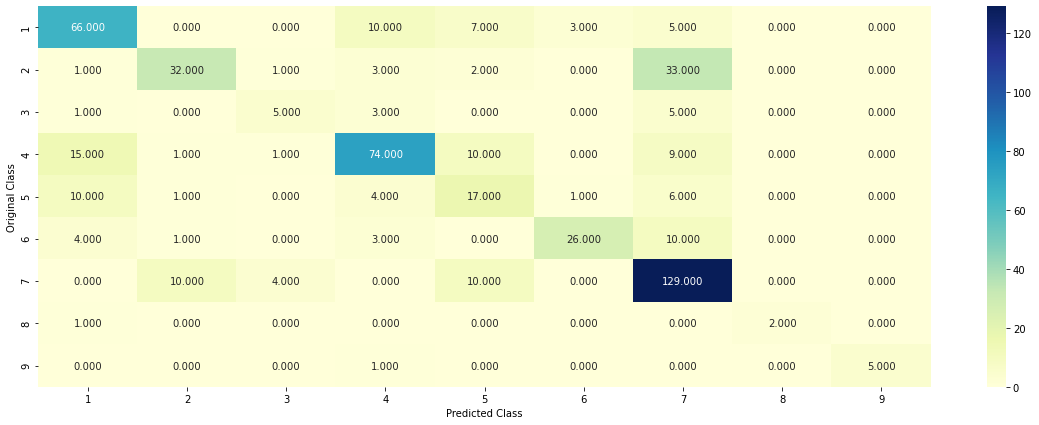

-------------------- Precision matrix (Columm Sum=1) --------------------


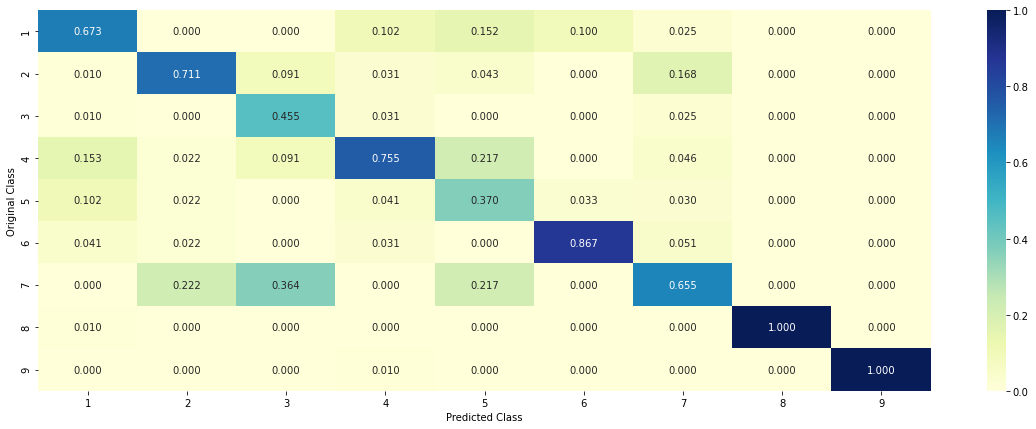

-------------------- Recall matrix (Row sum=1) --------------------


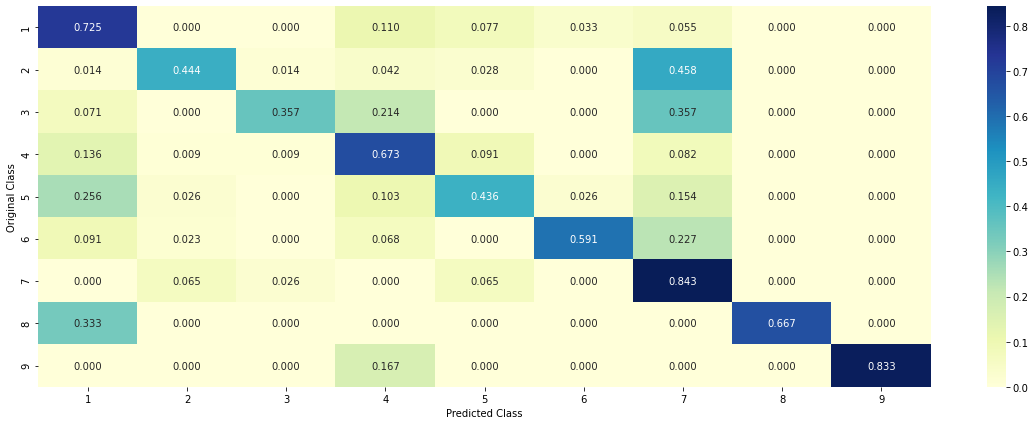

In [34]:
clf3 = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', loss='log', random_state=42)
predictAndPlot(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf3)

Log loss : 1.061646190976422
Number of mis-classified points : 0.3233082706766917
-------------------- Confusion matrix --------------------


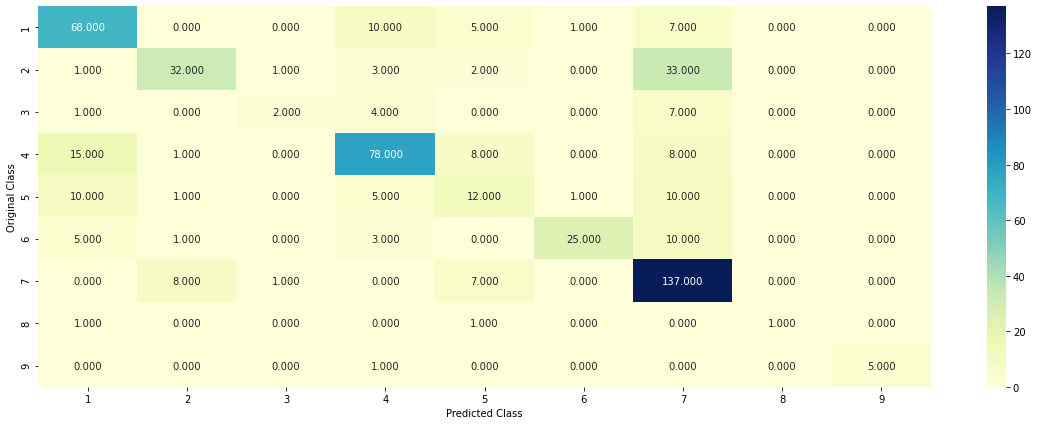

-------------------- Precision matrix (Columm Sum=1) --------------------


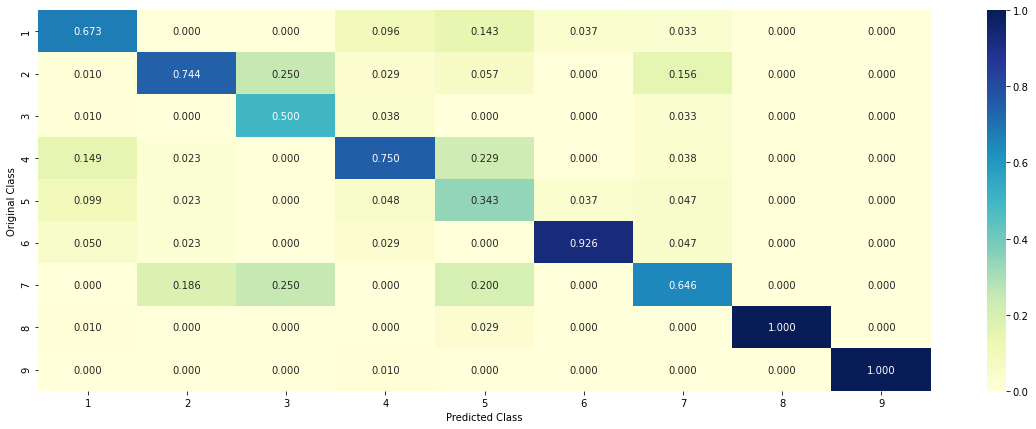

-------------------- Recall matrix (Row sum=1) --------------------


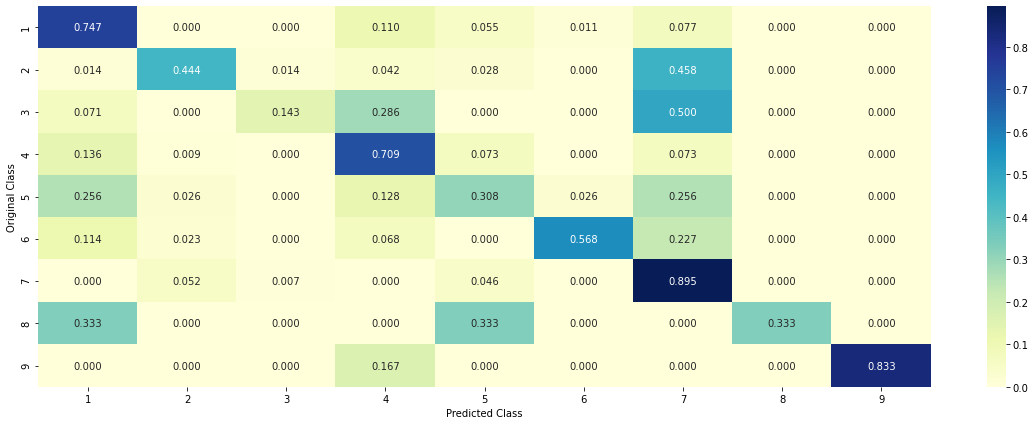

In [35]:
clf4 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', random_state=42)
predictAndPlot(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf4)

##### <h6 style="font-size:16px;">Linear Support Vector Machines</h6>

Log loss : 1.0669021448422757
Number of mis-classified points : 0.3233082706766917
-------------------- Confusion matrix --------------------


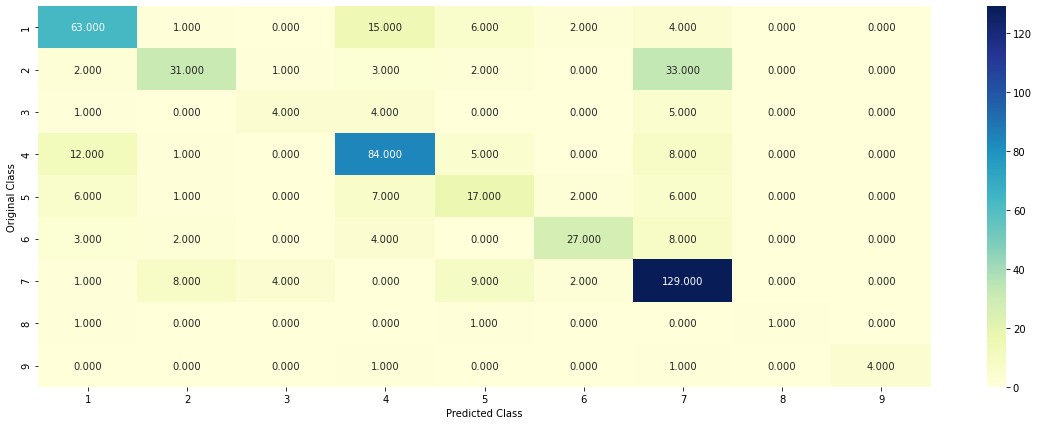

-------------------- Precision matrix (Columm Sum=1) --------------------


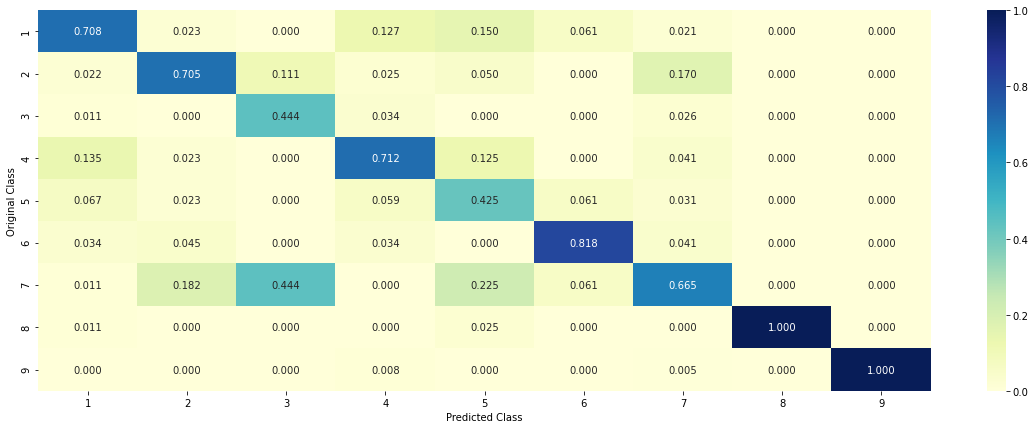

-------------------- Recall matrix (Row sum=1) --------------------


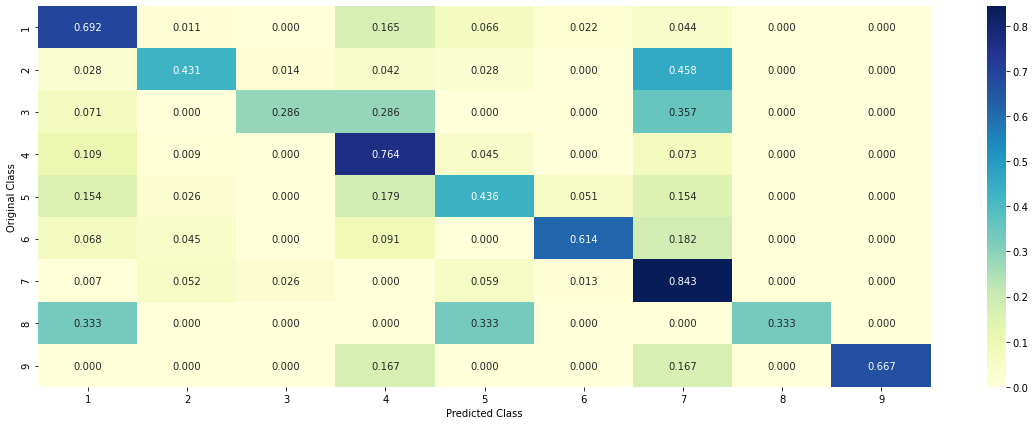

In [36]:
clf5 = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', random_state=42)
predictAndPlot(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf5)

<h6 style="font-size:16px;">Random Forest Classifier</h6>

Log loss : 1.1708696226193296
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


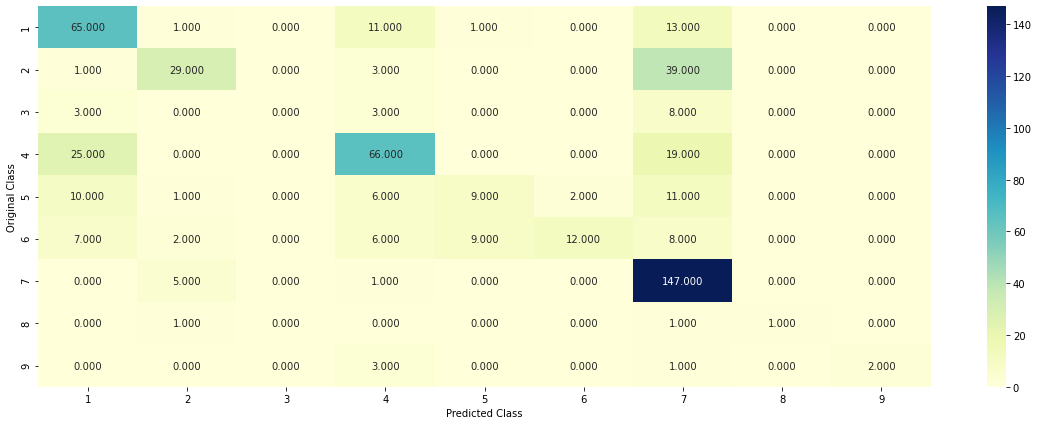

-------------------- Precision matrix (Columm Sum=1) --------------------


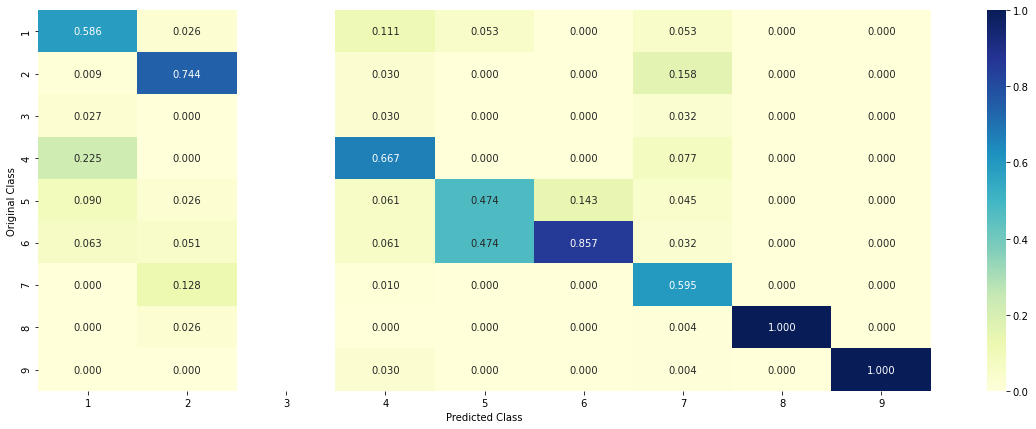

-------------------- Recall matrix (Row sum=1) --------------------


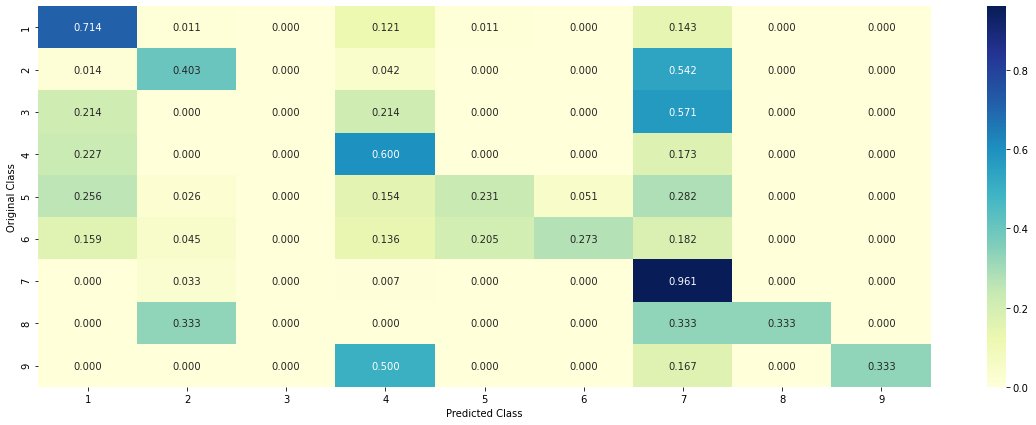

In [37]:
clf6 = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
predictAndPlot(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf6)